
Running example of classification using RandomForest

weighted f-measure 0.966
precision 0.965517241379
recall 0.965517241379

Running example of regression using RandomForest

rmse 0.263
r2 0.724
mae 0.115


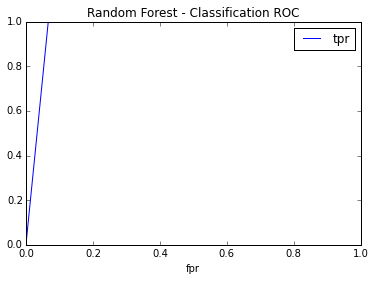

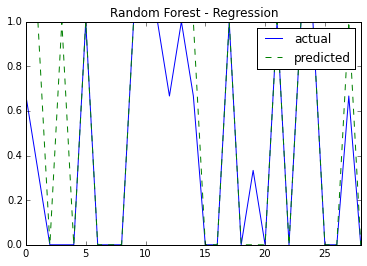

In [1]:
%matplotlib inline

import matplotlib
from matplotlib import pyplot as plt
from __future__ import print_function

import sys
import pandas

from pyspark import SparkContext
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.feature import StringIndexer
from pyspark.ml.regression import RandomForestRegressor
from pyspark.mllib.evaluation import MulticlassMetrics, RegressionMetrics
from pyspark.mllib.util import MLUtils
from pyspark.sql import Row, SQLContext
from sklearn import metrics


def testClassification(train, test):
	# Train a RandomForest model.
	# Setting featureSubsetStrategy="auto" lets the algorithm choose.
	# Note: Use larger numTrees in practice.
	rf = RandomForestClassifier(labelCol="indexedLabel", numTrees=3, maxDepth=4)
	model = rf.fit(train)
	predictionAndLabels = model.transform(test).select("prediction", "indexedLabel").map(lambda x: (x.prediction, x.indexedLabel))
	predictedDataFrame = sqlContext.createDataFrame(predictionAndLabels)
	

	# Creates data frame to plot ROC curve
	fpr, tpr, _ = metrics.roc_curve(predictedDataFrame.toPandas()['_1'].values, predictedDataFrame.toPandas()['_2'].values)
	
	
	df = pandas.DataFrame(dict(fpr=fpr, tpr=tpr))
	

	# ROC curve plot
	df.plot('fpr', 'tpr', title = 'Random Forest - Classification ROC')
	classificationMetrics = MulticlassMetrics(predictionAndLabels)
	print("weighted f-measure %.3f" % classificationMetrics.weightedFMeasure())
	print("precision %s" % classificationMetrics.precision())
	print("recall %s" % classificationMetrics.recall())


def testRegression(train, test):
	# Train a RandomForest model.
	# Note: Use larger numTrees in practice.
	rf = RandomForestRegressor(labelCol="indexedLabel", numTrees=3, maxDepth=4)
	model = rf.fit(train)
	predictionAndLabels = model.transform(test).select("prediction", "indexedLabel").map(lambda x: (x.prediction, x.indexedLabel))
	predictedDataFrame = sqlContext.createDataFrame(predictionAndLabels)	
	# Created data frame for visualization
	df = predictedDataFrame.toPandas()
	df.columns = ['actual', 'predicted']	
	# 'Line' plot is used here to differentiate 'actual' and 'predicted' values
	df.plot(style=['-','--'], title = 'Random Forest - Regression')
	regressionMetrics = RegressionMetrics(predictionAndLabels)
	print("rmse %.3f" % regressionMetrics.rootMeanSquaredError)
	print("r2 %.3f" % regressionMetrics.r2)
	print("mae %.3f" % regressionMetrics.meanAbsoluteError)

# Initializes SQL context
sqlContext = SQLContext(sc)

# Load and parse the data file into a dataframe.
df = MLUtils.loadLibSVMFile(sc, "/Data/Spark/MLLib/Sample_LibSVM_Data.txt").toDF()

# Map labels into an indexed column of labels in [0, numLabels)
stringIndexer = StringIndexer(inputCol="label", outputCol="indexedLabel")
si_model = stringIndexer.fit(df)
td = si_model.transform(df)
[train, test] = td.randomSplit([0.7, 0.3])


print('\nRunning example of classification using RandomForest\n')

testClassification(train, test)


print('\nRunning example of regression using RandomForest\n')
testRegression(train, test)
